# Final Practice
Today is all about practice.
You are given:
- a set of people that registered to your authentication system
    - with the file "people.csv" containing all their info
    - their associated reference embeddings in "people_embeddings.npy"
- a set of connections that will be used to train and validate the defense systems you deemed useful. This includes:
    - The file describing their connections: "train_connections.csv"
    - The associated connection embeddings: "train_connections_embeddings.npy"
- a test set of connections. The main question here is: which one of those test connections would you allow in? The set includes:
    - The file describing their connections: "test_connections.csv"
    - The associated connection embeddings: "test_connections_embeddings.npy"
    
Your mission is to produce a list of booleans 'predicted_test_labels', of the same length as the 'test_connections.csv', each boolean being True if you let then connection in and False otherwise. <br>
Use the "eval(predicted_test_labels)" function to get the accuracy of your system.

In [1]:
#Import packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb


In [2]:
#Import data
def load_files(csv_file="",npy_file=""): return pd.read_csv(csv_file), np.load(npy_file, allow_pickle=True)

train_connections, train_embeddings = load_files(csv_file="train_connections.csv", npy_file="train_connections_embeddings.npy")

In [3]:
#Your code
labels_list = [1 if connection_true else 0 for connection_true in train_connections['true_attempt']]
labels = np.array(labels_list) #we transform the list in a np.array to ease the next steps (idk why, but sklearn seems to like it...)

data_train = train_embeddings
labels_train = labels

#make labels 2 d
#labels_train = np.array([[1, 0] if label == 0 else [0, 1] for label in labels_train])

In [4]:
# load test_connections_embeddings.npy
test_embeddings = np.load("test_connections_embeddings.npy", allow_pickle=True)

In [5]:
def eval(predicted_test_labels):
    targets = np.load('solution.npy')
    accuracy = np.sum(targets==predicted_test_labels)/len(predicted_test_labels)
    print(f"The accuracy of your system is {100*accuracy}%!")
    
#eval(predicted_test_labels)

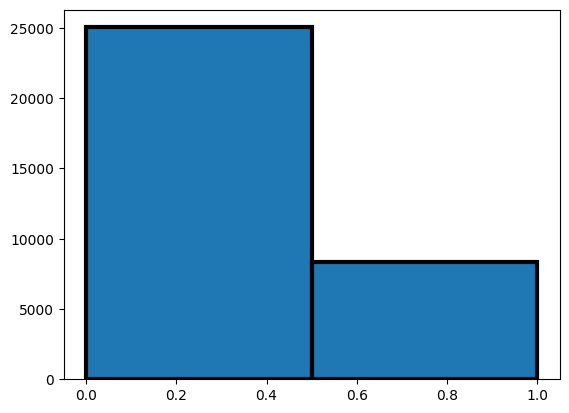

In [6]:
#plot distribution of labels in hist bucket = 2
# normalize axis to total percentage

plt.hist(labels_train, bins=2, edgecolor='black', linewidth=3)
plt.show()

In [31]:
# run xgboost for kagggle competition


#for i in range(1, 10):
    # train model
#    xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, n_estimators=800, max_depth=i, )
#    xgb_model.fit(data_train, labels_train)

    # predict test labels
#    predicted_test_labels = xgb_model.predict(test_embeddings)

#    print(i, eval(predicted_test_labels))
    # 76.49% accuracy


# 800, 3 -> 78.1 %

# 900, 2 -> 78.5% , seed 42


xgb_model = xgb.XGBClassifier(learning_rate = 0.2, objective="binary:logistic", random_state=42, n_estimators=900, max_depth=2)

xgb_model.fit(data_train, labels_train)

predicted_test_labels = xgb_model.predict(test_embeddings)

eval(predicted_test_labels)


The accuracy of your system is 77.7390513714199%!


In [10]:
# Decision trees with xgboost
#from sklearn.model_selection import KFold
#
#kf = KFold(n_splits=5, shuffle=True, random_state=122)
#for train_index, test_index in kf.split(data_train):
##    xgb_model = xgb.XGBClassifier(random_state=42).fit(
#    data_train[train_index], labels[train_index])
#
#predicted_test_labels = xgb_model.predict(test_embeddings)

#print(eval(predicted_test_labels))

# 75.49628731626004%

In [11]:
# Train a random forests models

#from sklearn.ensemble import RandomForestClassifier

#rf_model = RandomForestClassifier(n_estimators=40, max_depth=3, random_state=0)

#rf_model.fit(data_train, labels_train)

#predicted_test_labels = rf_model.predict(test_embeddings)

#eval(predicted_test_labels)

In [12]:
# train a random forests regressor

#from sklearn.ensemble import RandomForestRegressor

#rf_model = RandomForestRegressor(n_estimators=40, max_depth=3, random_state=0)

#rf_model.fit(data_train, labels_train)

#predicted_test_labels = rf_model.predict(test_embeddings)
#eval(predicted_test_labels)

# LMAOO

In [13]:
# use a non linear model SVM
#from sklearn import svm

#clf = svm.SVC()
#clf.fit(data_train, labels_train)

#predicted_test_labels = clf.predict(test_embeddings)


# 76.6% accuracy


In [14]:
# use a non linear svm with a kernel

#clf = svm.NuSVC(gamma="auto")
#clf.fit(data_train, labels_train)

#predicted_test_labels = clf.predict(test_embeddings)

# Wow that was 71% accuracy

In [15]:
# Make a voting system with XGBoost and Random forest

#predicted_test_labels = np.array([1 if (xgb_model.predict([test_embeddings[i]]) + rf_model.predict([test_embeddings[i]])) > 1 else 0 for i in range(len(test_embeddings))])

#eval(predicted_test_labels)



In [16]:
# use logisitc regression

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(data_train, labels_train)

predicted_test_labels = clf.predict(test_embeddings)

eval(predicted_test_labels)

The accuracy of your system is 74.58705864524929%!


In [17]:
import tensorflow as tf
from tensorflow import keras


# Define the model
model = keras.models.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(128,), kernel_regularizer=keras.regularizers.l2(0.02)),  # Input layer with ReLU activation
    keras.layers.BatchNormalization(),

    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.02)),


    
    keras.layers.Dropout(0.1),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.1),  # Dropout for regularization
    keras.layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# produce prediction on test data after each epoch 

# make callback

class PredictionCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        print("Predictions for epoch {}:".format(epoch+1))
        predictions = model.predict(test_embeddings)
        a = []
        for val in predictions:
            a.append(round(val[0]))
        eval(a)
        print("\n")
    
# train the model
model.fit(train_embeddings, labels, epochs=300, callbacks=[PredictionCallback()])



# To make predictions:
predictions = model.predict(test_embeddings)


a = []
for val in predictions:
    
    a.append(round(val[0]))

eval(a)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

KeyboardInterrupt: 

In [20]:
# create a deep learning model using primarily self attension

# Define the model

# import keras



from keras_self_attention import SeqSelfAttention

model = keras.models.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(128,), kernel_regularizer=keras.regularizers.l2(0.02)),  # Input layer with ReLU activation
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.02)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# produce prediction on test data after each epoch 

# make callback

class PredictionCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        print("Predictions for epoch {}:".format(epoch+1))
        predictions = model.predict(test_embeddings)
        a = []
        for val in predictions:
            a.append(round(val[0]))
        eval(a)
        print("\n")
    
# train the model
model.fit(train_embeddings, labels, epochs=100, callbacks=[PredictionCallback()])



# To make predictions:
predictions = model.predict(test_embeddings)



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 26881 (105.00 KB)
Trainable params: 2688

KeyboardInterrupt: 

In [ ]:
# Deep learning 

#from sklearn.neural_network import MLPClassifier
#import numpy as np

#takes in 128 vector and outputs a 1 or 0

#hidden_layer_sizes = (128, 64, 32, 16, 8, 4, 2)

#clf = MLPClassifier(random_state=1, max_iter=10, hidden_layer_sizes=hidden_layer_sizes, batch_size=40).fit(data_train, labels_train)
#predicted_test_labels = clf.predict(test_embeddings)



/Users/malcolmkrolick/Documents/GitHub/Machine_Learning_For_Security_Solutions/MLSecuritySolutions/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
a = []


for val in predicted_test_labels:
    a.append(val)

eval(a)

The accuracy of your system is 72.07152598878618%!


In [ ]:
# use KNN

#for i in range(2, 10):
#    knn = KNeighborsClassifier(n_neighbors=i)
#    knn.fit(data_train, labels_train)

#    predicted_test_labels = knn.predict(test_embeddings)
#    print(i, eval(predicted_test_labels))


# 72% accuracy

The accuracy of your system is 72.73829368086074%!
2 None
The accuracy of your system is 71.69268070919837%!
3 None
The accuracy of your system is 72.17760266707077%!
4 None
The accuracy of your system is 71.859372632217%!
5 None
The accuracy of your system is 72.48067889074102%!
6 None
The accuracy of your system is 71.57145021973025%!
7 None
The accuracy of your system is 72.11698742233672%!
8 None
The accuracy of your system is 71.67752689801486%!
9 None


In [ ]:

#from sklearn.cluster import KMeans, AgglomerativeClustering

#def date_to_num(date):
#    h_,d_ = date.split(' ')
#    h,m,s = h_.split(':')
#    d,mo,y = d_.split('-')
#    y = int(y)-2019
#    return int(s) + 60*(int(m) + 60*(int(h) + 24*(int(d) + 29*(int(mo) + 12*y))))

#dates = list(train_connections['dates']) # list of the ips, as strings: '255.255.255.255'
#years = [int(date.split('-')[-1]) for date in dates]
#print(f"The years range from {np.min(years)} to {np.max(years)}")
#print(f"We can go from the str :'{dates[0]}' to a global number representing the total date from 2019 in seconds: {date_to_num(dates[0])}")
#train_data = np.array([ date_to_num(date) for date in dates]) #now we have an array, composed of lists ['255','255','255','255']
#train_data = train_data.astype(int) #we convert it to int as we want to deal with numbers here, which gives us something like [255, 255, 255, 255]
#print(f"the shape of the train data is: {train_data.shape}")

#train_data_sorted = np.array(sorted(train_data))
#diff = train_data_sorted[1:] - train_data_sorted[:-1]
#plt.hist(diff, bins=100)
#plt.show()

#cluster_labels = AgglomerativeClustering(distance_threshold=60*60, n_clusters=None).fit_predict(train_data.reshape(-1,1)) #finding which dates are in which cluster
# we don't chose the number of clusters, but if 2 samples are separated by more than 1hour, then it's a new group
#print(f"Found {len(set(cluster_labels))} clusters of connections hapening in the same hour")

In [ ]:
# use k means

#from sklearn.cluster import KMeans

#kmeans = KMeans(n_clusters=4000, random_state=0).fit(data_train)

#predicted_test_labels = kmeans.predict(test_embeddings)
#print(eval(predicted_test_labels))





/Users/malcolmkrolick/Documents/GitHub/Machine_Learning_For_Security_Solutions/MLSecuritySolutions/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KeyboardInterrupt: 

## Evaluation
Once you have your 'predicted_test_labels' list, you can use the eval function below:

NameError: name 'predicted_test_labels' is not defined

Our accuracy is not great right now, because we accept everyone! but I'm sure you can improve from there! 

In [ ]:


#fig = plt.figure(figsize=(10,10))

#X = connection_embeddings[:,0]
#Y = connection_embeddings[:,1]

#labels = np.array(connections['logins'])
#true_attempt = np.array(connections['true_attempt'])
#size=5

##ax_1 = plt.subplot(221) #First plot
#for i in set(labels):
#    ax_1.scatter(X[labels==i], Y[labels==i], label=i, s=size)
#ax_1.set_title("Scatterplot by login used")
    
#ax_2 = plt.subplot(222) #Second plot
#ax_2.scatter(X[true_attempt==False], Y[true_attempt==False], label='False', s=size)
##ax_2.scatter(X[true_attempt], Y[true_attempt], label='True', s=size)
#ax_2.set_title("Scatterplot by true/false attempt")
#ax_2.legend()


#ax_3 = plt.subplot(212)#third plot
#true_scores = list(connections[connections['true_attempt']==True]['scores'])
#false_scores = list(connections[connections['true_attempt']==False]['scores'])
#ax_3.hist(false_scores, label='False Scores', bins=100, alpha=0.5)
#ax_3.hist(true_scores,  label='True Scores',  bins=100, alpha=0.5)
#ax_3.set_title("Scores")
#ax_3.legend()

#plt.show()